# Applying the bilinear system identification Landau-Zener 

In [1]:
from qutip import *
import matplotlib.pyplot as plt
from bi_sys_id_quantum import *

In [2]:
def get_quantum_expectation(pulse, times):
    """
    Calculate the time-series for the expectation value of a quantum observable 
    pulse - a function of two arguments
    """
    Hamiltonian = [sigmaz(), [sigmax(), pulse]]
    
    return mesolve(
        Hamiltonian, basis(2, 0), times, [], [sigmax(), sigmaz()] #[0.001 * sigmaz() + sigmax()]
    ).expect

In [3]:
p = 100
dt = 0.01
F = 20.

times = dt * np.arange(500)

In [4]:
original_responses = [
    [
        get_quantum_expectation(lambda t, args: F * (t < N * dt), times)
    ] for N in range(1, p + 1)    
]

original_responses = np.array(original_responses)

In [5]:
#rank, sigma = estimate_rank(original_responses, alpha=int(original_responses.shape[1] / 2))

In [6]:
"""
plt.title("$y^{(N)}(t)$ Input/Original Responses")
plt.plot(original_responses.T)
plt.xlabel("Time in units of $\Delta t$")
plt.ylabel("Responses")
plt.savefig('input.pdf')
#plt.xlim(0, 200)
plt.show()
"""

'\nplt.title("$y^{(N)}(t)$ Input/Original Responses")\nplt.plot(original_responses.T)\nplt.xlabel("Time in units of $\\Delta t$")\nplt.ylabel("Responses")\nplt.savefig(\'input.pdf\')\n#plt.xlim(0, 200)\nplt.show()\n'

In [7]:
reconstructed = bi_sys_id_my_version(
    original_responses, 
    alpha = int(original_responses.shape[-1] / 2),
    dt = dt,
    v = [F],
    #rank=4
)

In [8]:
reconstructed

Reconstructed(Ac=array([[ 1.10685955e-03,  5.56773388e-02, -1.47757560e-02],
       [-3.15609465e-01, -1.22931705e-01,  1.91932274e+00],
       [ 3.01112442e-02, -2.08245432e+00,  1.21824846e-01]]), C=array([[-0.05914233, -0.46756573,  0.42439298],
       [-0.95860947, -0.00577462, -0.02528888]]), Nc=[array([[ 0.09037928, -0.8619801 , -0.87935358],
       [ 2.18037896, -0.00767469,  0.03616217],
       [ 2.41477962, -0.12857919, -0.08270449]])], x0=array([[-1.03847565],
       [-0.02509575],
       [-0.17236769]]))

In [9]:
reconstructed_responses = get_training_responses(reconstructed, times, p, [F])

In [10]:
np.abs(reconstructed_responses.reshape(-1) - original_responses.reshape(-1)).max()

6.324026768111946e-05

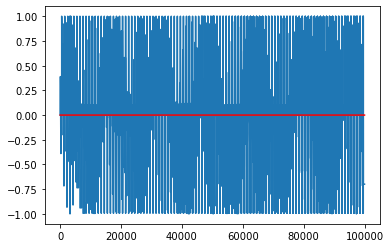

In [11]:
plt.plot(reconstructed_responses.reshape(-1))
plt.plot(reconstructed_responses.reshape(-1) - original_responses.reshape(-1), 'r')
plt.show()

In [12]:
"""
plt.title("Original responses")
plt.plot(original_responses.T)
plt.xlabel("time in units of $\Delta t$")
plt.ylabel("$\\langle \sigma_z + \sigma_x \\rangle$ \t(a.u.)")
plt.savefig('input.pdf')
plt.show()

plt.title("Reconstructed responses")
plt.plot(reconstructed_responses.T)
plt.xlabel("time in units of $\Delta t$")
plt.ylabel("$\\langle \sigma_z + \sigma_x \\rangle$ \t(a.u.)")
plt.savefig('response.pdf')
plt.show()
"""

'\nplt.title("Original responses")\nplt.plot(original_responses.T)\nplt.xlabel("time in units of $\\Delta t$")\nplt.ylabel("$\\langle \\sigma_z + \\sigma_x \\rangle$ \t(a.u.)")\nplt.savefig(\'input.pdf\')\nplt.show()\n\nplt.title("Reconstructed responses")\nplt.plot(reconstructed_responses.T)\nplt.xlabel("time in units of $\\Delta t$")\nplt.ylabel("$\\langle \\sigma_z + \\sigma_x \\rangle$ \t(a.u.)")\nplt.savefig(\'response.pdf\')\nplt.show()\n'

## Testing the reconstructed model

In [22]:
pulse = lambda t, args=0: 200. * np.sin(70. * t) # 1e-2* np.sin(2 * (t + 0.5 * t ** 2))

In [23]:
#import copy
#model = copy.deepcopy(reconstructed)
#model.Ac[:] = 0.5 * (model.Ac - model.Ac.conj().T)
#model.Nc[0][:] = 0.5 * (model.Nc[0] - model.Nc[0].conj().T)
model = reconstructed

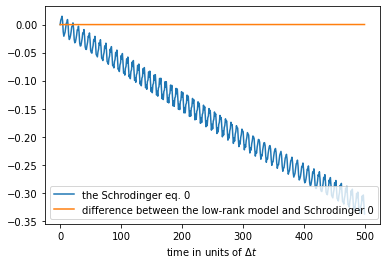

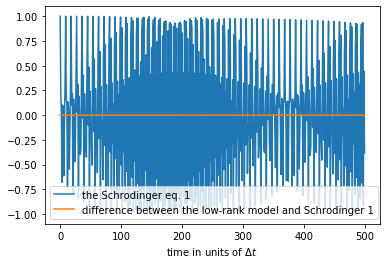

In [24]:
for num, (exact, predicted) in enumerate(zip(get_quantum_expectation(pulse, times), get_response(model, pulse, times))):
    plt.plot(exact, label='the Schrodinger eq. {}'.format(num))
    plt.plot(exact - predicted, label='difference between the low-rank model and Schrodinger {}'.format(num))

    plt.xlabel("time in units of $\Delta t$")
    #plt.ylabel("$\\langle \sigma_z + \sigma_x \\rangle$ \t(a.u.)")

    plt.legend()
    plt.savefig('Fig_LandauZener_Test.pdf')

    plt.show()

In [16]:
np.linalg.eig(model.Ac)

(array([2.22040286e-14+0.j        , 3.47225637e-10+1.99998545j,
        3.47225637e-10-1.99998545j]),
 array([[-0.9862223 +0.j        , -0.01925963+0.00416802j,
         -0.01925963-0.00416802j],
        [-0.02383678+0.j        ,  0.04187128-0.69190784j,
          0.04187128+0.69190784j],
        [-0.16369909+0.j        ,  0.72050123+0.j        ,
          0.72050123-0.j        ]]))

In [17]:
(
    tensor(qeye(2), sigmaz()) - tensor(sigmaz(), qeye(2))
).eigenenergies()

array([-2.,  0.,  0.,  2.])

In [18]:
(
    tensor(qeye(2), sigmax()) - tensor(sigmax(), qeye(2))
).eigenenergies()

array([-2.0000000e+00,  0.0000000e+00,  6.9388939e-18,  2.0000000e+00])

In [19]:
np.linalg.eig(model.Nc[0])

(array([ 1.61301465e-07+2.0000011j,  1.61301465e-07-2.0000011j,
        -2.18241651e-07+0.j       ]),
 array([[ 0.0518836 +0.52036749j,  0.0518836 -0.52036749j,
         -0.01411241+0.j        ],
        [ 0.56755144-0.06582159j,  0.56755144+0.06582159j,
         -0.71477971+0.j        ],
        [ 0.6325177 +0.j        ,  0.6325177 -0.j        ,
          0.69920727+0.j        ]]))

In [20]:
reconstructed.Ac

array([[ 1.10685955e-03,  5.56773388e-02, -1.47757560e-02],
       [-3.15609465e-01, -1.22931705e-01,  1.91932274e+00],
       [ 3.01112442e-02, -2.08245432e+00,  1.21824846e-01]])

In [21]:
"""
    l = 20 - 4

    transpose = np.array(
        [[1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]]
    )
        
    Phi = np.block([
        [0.5 * (np.eye(4) + transpose), np.zeros((4, l))],
        [np.zeros((l, 4)), np.eye(l)],
    ])

    Phi[1, -1] = Phi[2, -2] = Phi[-1, 1] = Phi[-2, 2] = 0.5
"""

'\n    l = 20 - 4\n\n    transpose = np.array(\n        [[1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]]\n    )\n        \n    Phi = np.block([\n        [0.5 * (np.eye(4) + transpose), np.zeros((4, l))],\n        [np.zeros((l, 4)), np.eye(l)],\n    ])\n\n    Phi[1, -1] = Phi[2, -2] = Phi[-1, 1] = Phi[-2, 2] = 0.5\n'